# Dossier : Scraping Dauphine

## Introduction & Problématique :

### Introduction

Nous allons effectuer  un scraping de données sur le site de Dauphine : https://dauphine.psl.eu/formations/masters. 
Notre objectif est de récupérer des informations utiles telles que le taux d'insertion professionnelle, le salaire médian après l'obtention du diplôme, ainsi que le délai moyen d'insertion sur le marché du travail.

Notre démarche se fera en plusieurs étapes : 

Ouverture d'un nouveau notebook
Importation des bibliothèques nécessaires (BeautifulSoup, NumPy, Pandas)
Analyse de la structure du site pour identifier les balises HTML pertinentes
Exécution du script de scraping

La motivation de cet exercice est double : d'un côté, dans notre recherche d'un master, nous voulons avoir un ensemble de statistiques descriptives pour chaque spécialisation. D'autre part, nous voulons mettre nos compétences à l'œuvre nos compétences  en matière de scraping de données.

La collecte de ces données nous permettra de réaliser une analyse statistique approfondie et de comparer les différents masters selon le salaire médian et l’insertion professionnelle. 
Cela va nous permettre d’avoir une vue d’ensemble et de comparer plus facilement les masters entre eux.

Ainsi, ce qui nous amène à poser clairement la problématique de notre exercice. 

### Problématique : 

Quelles sont les différences en termes de salaire médian à l'entrée dans la vie active et de taux d'insertion professionnelle entre les diplômés des secteurs de la finance, de l'économie et du management à l'Université Paris Dauphine ?

## Partie 1 - Scrap : Algorithme de récupération des données

### Librairies

In [1]:
# On commence par appeler les librairies que nous allons utiliser pour scraper.

import requests 
from bs4 import BeautifulSoup
import sys
import pandas as pd
import numpy as np
import re

# Et les librairies utilisées pour le graphique et le tableau.
import matplotlib.pyplot as plt
import seaborn as sns

### Dataframe des Masters

In [2]:
# Définition de l'url de la page des masters de Dauphine et test de la connexion.
url = 'https://dauphine.psl.eu/formations/masters'

response = requests.get(url)
if response.ok:
    print('ok')
else:
    sys.exit("BUG : Echec de connexion") 
    
# Récupération du code HTML de la page des masters de Dauphine.
big_soup = BeautifulSoup(response.text, 'lxml')

# Séléction de la partie du code HTML qui contient les informations sur les masters.
mstr = big_soup.find('table', {'class':'schema landing-master'})

# Extraction des liens et noms des programmes de masters.
mstrs = mstr.findAll('a')
mentions = mstr.findAll('div', {'class':'mention'})

# Initialisation des listes pour stocker les liens et noms des masters.
links1 = []
names1 = []

# Extraction des liens vers les pages de masters.
for a in mstrs :
    lnk1 = a['href']
    links1.append('https://dauphine.psl.eu' + lnk1)
    
# Extraction des noms de masters.
for div in mentions :
    name1 = div.text
    names1.append(name1)

# Supression des masters informatiques et journalisme.
del links1[8:10]
del names1[8:10]

# Création d'un DataFrame à partir des liens et noms des masters, et filtrage des masters 
# par domaine d'intérêt : économie, finance et management.
data1 = {'Links':links1[2:15], 'Names':names1[2:15]}
df1 = pd.DataFrame(data1)

ok


### DataFrame des Masters 2

In [3]:
# Initialisation des listes pour stocker les liens et noms des masters 2.
links_y = []
names_y = []

# Pour chaque lien récupéré, définition de l'url de la page du master et test de la connexion.
for y in df1.Links :
    url_y = y
    response = requests.get(url_y)
    
    # Si la connexion est réussie, récupération du code HTML et séléction des balises contenant les liens et noms des masters 2.
    if response.ok:
        soup_y = BeautifulSoup(response.text, 'lxml')
        spé = soup_y.find('div', {'class':'swiper-slide colonne-3'})
        m2 = spé.findAll('a')
        
        # Pour chaque balise, ajout de lien et nom correspondant dans les listes préparées.
        for lien in m2 :
            lnk_y = lien['href']
            links_y.append('https://dauphine.psl.eu' + lnk_y)
            name_y = lien.text
            names_y.append(name_y)
    else:
        sys.exit("BUG : Echec de connexion")

# Suppression des entrées non pertinentes (MBA, etc., qui sont sources d'erreurs) du résultat final.
del links_y[41:43]
del names_y[41:43]       
    
# Création d'un DataFrame avec les liens et les noms des masters 2.
data_z = {'Links':links_y, 'Names':names_y}
df_z = pd.DataFrame(data_z)

### DataFrame final / CSV

In [4]:
# Préparation des listes pour collecter les informations clés des masters 2.
mois = []
insertion = []
salaire = []

# Parcours des liens M2 pour récupérer les données recherchées.
for x in df_z.Links :
    url_x = x
    
    # Vérification d'accès au site pour chaque lien
    response = requests.get(url_x)
    if response.ok: 
        
        # Extraction du code HTML et des informations recherchées
        soup_x = BeautifulSoup(response.text, 'lxml')
        infos_x = soup_x.findAll('div', {'class':'number custom-color4'})
        
        # Ajout de chaque information à une liste temporaire.
        infs=[]
        for info in infos_x :
            inf_x = info.text
            infs.append(inf_x)
            
        # Gestion des cas où des informations sont manquantes puis ajout aux listes préparées.
        if len(infs) == 3 :
            mois.append(infs[0])
            insertion.append(infs[1])
            salaire.append(infs[2])
        else : 
            if len(infs) == 2 :    
                mois.append(infs[0])
                insertion.append(infs[1])
                salaire.append(None)
            else : 
                mois.append(None)
                insertion.append(None)
                salaire.append(None)
    else:
        sys.exit("BUG : Echec de connexion")

# Création d'une liste dans laquelle j'ajoute 1 pour les master économie, 2 pour finance et 3 pour managemant afin de 
# faciliter le traitement des données.
m1 = []
for noms in names_y[0:13] :
    m1.append('1')
for noms in names_y[13:25] :
    m1.append('2')
for noms in names_y[25:51] :
    m1.append('3')
        
# Création d'un DataFrame final avec toutes les données collectées.
data_y = {'Names':names_y, 'Type de Master':m1, "Recherche d'emploi en mois":mois,"Taux d'insertion en %":insertion, 
          'Salaire médian en €':salaire}
df_y = pd.DataFrame(data_y)

# Nettoyage des données pour améliorer la lisibilité et le traitement des données.
df_y['Salaire médian en €'] = df_y['Salaire médian en €'].str.replace(r",",'', regex=False)
df_y['Salaire médian en €'] = df_y['Salaire médian en €'].str.replace(r"\r\n",'', regex=True)
df_y['Salaire médian en €'] = df_y['Salaire médian en €'].str.replace(r" ",'', regex=False)
df_y['Salaire médian en €'] = df_y['Salaire médian en €'].str.replace(r"€",'', regex=False)
df_y["Taux d'insertion en %"] = df_y["Taux d'insertion en %"].str.replace(r"%",'', regex=False)
df_y["Taux d'insertion en %"] = df_y["Taux d'insertion en %"].str.replace(r"\r\n",'', regex=True)
df_y["Taux d'insertion en %"] = df_y["Taux d'insertion en %"].str.replace(r" ",'', regex=False)
df_y["Taux d'insertion en %"] = df_y["Taux d'insertion en %"].str.replace(r",",'.', regex=False)
df_y["Recherche d'emploi en mois"] = df_y["Recherche d'emploi en mois"].str.replace(r"Mois",'', regex=False)
df_y["Recherche d'emploi en mois"] = df_y["Recherche d'emploi en mois"].str.replace(r"Month",'', regex=False)
df_y["Recherche d'emploi en mois"] = df_y["Recherche d'emploi en mois"].str.replace(r"mois",'', regex=False)
df_y["Recherche d'emploi en mois"] = df_y["Recherche d'emploi en mois"].str.replace(r" ",'', regex=False)
df_y["Recherche d'emploi en mois"] = df_y["Recherche d'emploi en mois"].str.replace(r"\r\n",'', regex=True)

# Suppression des lignes avec des données manquantes.
df_y = df_y.dropna()

# Affichage du DataFrame nettoyé afin de vérifier visuellement.
df_y

# Exportation du DataFrame en fichier CSV pour analyse de données.
df_y.to_csv('./Masters_Dauphine.csv', sep = ';', index = False, encoding = 'utf-8')

## Partie 2 - Tableau & Graphique:

### Visualisation du tableau

In [5]:
# Importation du CSV
master_df = pd.read_csv('./Masters_Dauphine.csv', sep = ';')
master_df

,Names,Type de Master,Recherche d'emploi en mois,Taux d'insertion en %,Salaire médian en €
0,Affaires internationales,1,1,88.0,46200
1,Aide à la décision et évaluation des politique...,1,1,66.7,21575
2,Diagnostic économique international,1,4,100.0,47050
3,Economie internationale et développement,1,1,80.0,36800
4,Supply Chain internationale,1,1,100.0,43000
5,Développement durable et responsabilité des or...,1,1,95.0,39500
6,Conflict Transformation and Peace Studies,1,1,80.0,33550
7,"Banque, finance, assurance",1,1,100.0,81000
8,Economie et gestion des organisations sanitair...,1,1,93.3,39200
9,Evaluation médico-économique et accès au marché*,1,1,81.8,45000


### Interprétation du tableau

Le tableau présenté ci-dessus permet de visualiser des statistiques descriptives essentielles pour une compréhension globale des différents masters offerts par l'Université Paris-Dauphine, classés selon leur domaine : Économie (1), Finance (2), et Management (3). 

Chaque master y est présenté par ordre alphabétique au sein de sa propre spécialisation, ce qui permet ainsi d'identifier facilement le taux d'insertion professionnelle en pourcentage, le niveau de salaire médian, ainsi que la durée de recherche d'emploi avant de décrocher un CDI.

En l'absence de ce tableau, toute personne qui désire obtenir ces caractéristiques aurait dû consulter individuellement chaque master 1, puis chaque spécialisation de master 2, et ce, pour les 48 formations proposées, en scrollant jusqu'en bas de chaque page dédiée pour y accéder.

### Visualisation du graphique 1 : Salaire médian - Economie

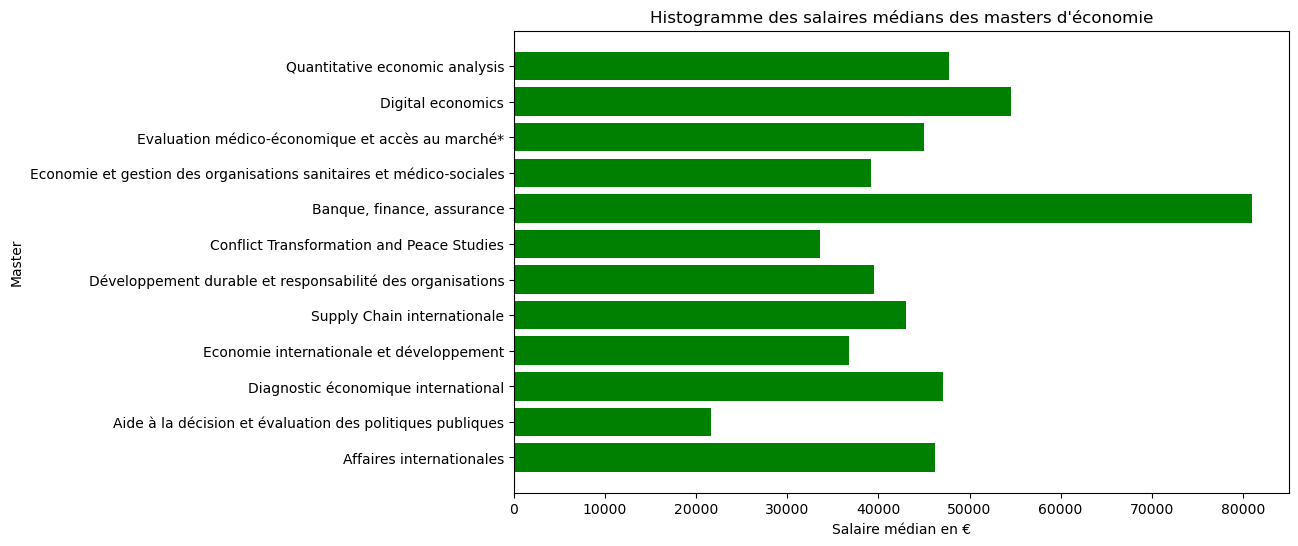

In [6]:
# Création de DataFrames pour chaque type de master afin d'effectuer des graphiques pertinents.
economie_df = master_df.loc[master_df['Type de Master'] == 1]
finance_df = master_df.loc[master_df['Type de Master'] == 2]
management_df = master_df.loc[master_df['Type de Master'] == 3]

# Définition de la taille du graphique.
plt.figure(figsize=(10, 6))

# Création de l'histogramme horizontal.
plt.barh(economie_df['Names'], economie_df['Salaire médian en €'], color='green')

# Ajout des labels et du titre.
plt.xlabel('Salaire médian en €')
plt.ylabel('Master')
plt.title("Histogramme des salaires médians des masters d'économie")

# Affichage du graphique.
plt.show()

### Interprétation du graphique 1 : Salaire médian - Economie

L'analyse de l'histogramme montre qu'au sein des masters en économie, le master Banque Finance Assurance se démarque avec un salaire médian impressionnant de 81 000 euros annuels, signifiant que la moitié des diplômés gagnent moins et l'autre moitié plus que cette somme. Cette donnée n'est pas étonnante au vu des professions issues de cette filière, telles que les conseillers en fusion-acquisition, un rôle qui fût notamment occupé par le président E. Macron chez Rothschild ou encore les gestionnaires d'actifs responsables des portefeuilles financiers de clients.*

Cependant, le master en économie dont le salaire médian est le plus modeste est celui d'« Aide à la décision et Évaluation des politiques publiques », qui s'élève à 21 575 euros. Cet écart s'explique en partie par le fait que 70% des diplômés travaillent à l'étranger, où ce salaire est souvent considéré comme attractif, notamment au Maroc ou en Tunisie, où il représente environ cinq fois le salaire moyen local.*

### Visualisation du graphique 2 : Salaire médian - Finance

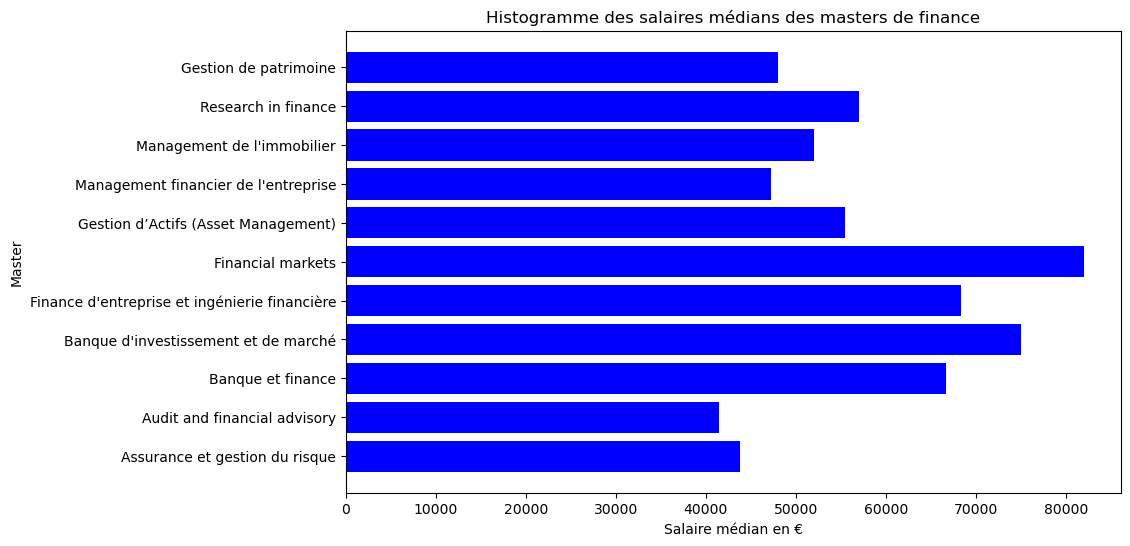

In [7]:
# Définition de la taille du second graphique
plt.figure(figsize=(10, 6))

# Création de l'histogramme horizontal
plt.barh(finance_df['Names'], finance_df['Salaire médian en €'], color='blue')

# Ajout des labels et du titre.
plt.xlabel('Salaire médian en €')
plt.ylabel('Master')
plt.title('Histogramme des salaires médians des masters de finance')

# Affichage du graphique
plt.show()

### Interprétation du graphique 2 : Salaire médian - Finance

Concernant les masters en finance, l'histogramme met en lumière que le master “Financial Marke”  est en tête avec un salaire médian supérieur à 81 000 euros, favorisant une carrière dans des fonctions opérationnelles stratégiques au sein d'entreprises réputées mondialement. 
À titre d'illustration, Eric Elbaz, issu de ce master, occupe aujourd'hui le poste de Directeur Général chez Goldman Sachs.*

Le master en finance le moins rémunérateur, « Audit and Financial Advisory », a quant à lui un salaire médian légèrement supérieur à 41 000 euros, montrant une orientation un peu plus marquée vers le management et la comptabilité, avec des perspectives de carrière au sein de l'entreprise potentiellement moins orientées vers des postes de haute direction.

### Visualisation du graphique 3 : Salaire médian - Management

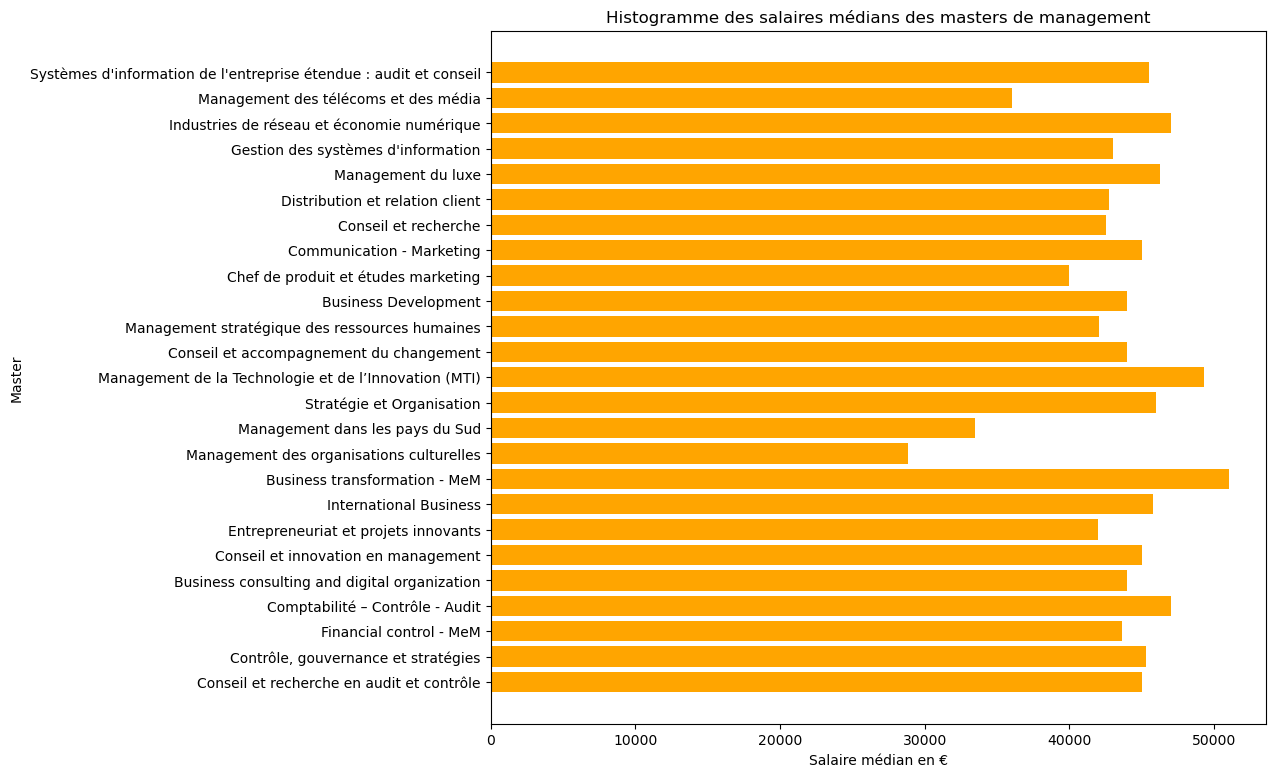

In [8]:
# Définition de la taille du troisième graphique
plt.figure(figsize=(10, 9))

# Création de l'histogramme horizontal
plt.barh(management_df['Names'], management_df['Salaire médian en €'], color='orange')

# Ajout des labels et du titre.
plt.xlabel('Salaire médian en €')
plt.ylabel('Master')
plt.title('Histogramme des salaires médians des masters de management')

# Affichage du graphique
plt.show()

### Interprétation du graphique 3 : Salaire médian - Management

Dans la catégorie management, le master « Business Transformation- Mem » se démarque avec un salaire médian de 51 000 euros annuels, ce qui en fait le programme le mieux rémunéré, orienté vers le leadership en transformation managériale et éthique.

À l'opposé, le master « Management des organisations culturelles » présente le salaire médian le moins élevé de la catégorie, soit 28 824 euros annuels.

### Visualisation du graphique 4 : Moyenne des taux d'insertion 

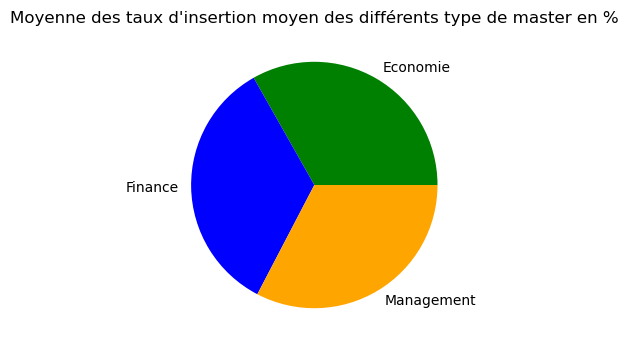

 Economie = 90 % 
 Finance = 93 % 
 Management = 88 %


In [9]:
# Création de variale contenant la moyenne des taux d'insertion de chaque type de master.
mean_eco_insert = sum(economie_df["Taux d'insertion en %"])/len(economie_df["Taux d'insertion en %"])
mean_fin_insert = sum(finance_df["Taux d'insertion en %"])/len(finance_df["Taux d'insertion en %"])
mean_man_insert = sum(management_df["Taux d'insertion en %"])/len(management_df["Taux d'insertion en %"])

# Ajout de ces variables dans une liste pour création du graphique.
all_means_insert = [mean_eco_insert, mean_fin_insert, mean_man_insert]

# Définition des labels et couleurs que le graphique affichera.
moyennes = ["Economie", "Finance", "Management"]
colors = ['green', 'blue', 'orange'] 

# Création de la taille, du titre et du contenu du graphique.
plt.figure(figsize=(4, 4))
plt.title("Moyenne des taux d'insertion moyen des différents type de master en %")
plt.pie(all_means_insert, labels=moyennes, colors=colors)

# Affichage du graphique et de la légende.
plt.show()
print(' Economie =', int(mean_eco_insert), '%', '\n', 
      'Finance =', int(mean_fin_insert), '%','\n', 
      'Management =', int(mean_man_insert), '%')

### Interprétation du graphique 4 : Moyenne des taux d'insertion 

Le graphique en camembert récapitule la moyenne des taux d'insertion par catégorie de master et indique que la finance se situe en tête avec un peu plus de 93%, tandis que le management enregistre le taux le plus bas avec 88%. 
Ces taux sont tout de même représentatifs de l'excellence de l'Université Paris-Dauphine.

### Visualitation du graphique 5 : Moyenne des salaires médians

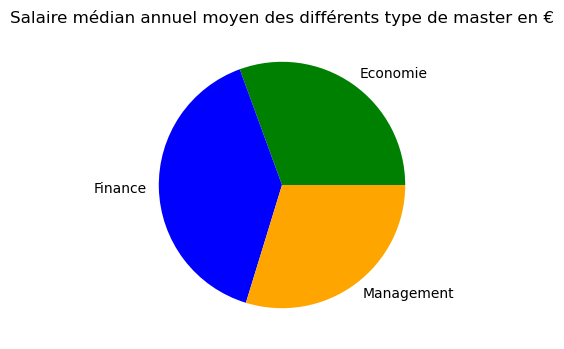

 Economie = 44597 € 
 Finance = 57911 € 
 Management = 43373 €


In [10]:
# Création de variale contenant la moyenne des salaires médians de chaque type de master.
mean_eco_salary = sum(economie_df['Salaire médian en €'])/len(economie_df['Salaire médian en €'])
mean_fin_salary = sum(finance_df['Salaire médian en €'])/len(finance_df['Salaire médian en €'])
mean_man_salary = sum(management_df['Salaire médian en €'])/len(management_df['Salaire médian en €'])

# Ajout de ces variables dans une liste pour création du graphique.
all_means_salary = [mean_eco_salary, mean_fin_salary, mean_man_salary]

# Création de la taille, du titre et du contenu du graphique.
plt.figure(figsize=(4, 4))
plt.title("Salaire médian annuel moyen des différents type de master en €")
plt.pie(all_means_salary, labels=moyennes, colors=colors)

# Affichage du graphique et de la légende.
plt.show()
print(' Economie =', int(mean_eco_salary), '€', '\n', 
      'Finance =', int(mean_fin_salary), '€', '\n', 
      'Management =', int(mean_man_salary), '€')

### Interprétation du graphique 5 : Moyenne des salaires médians

Un autre graphique en camembert résume le salaire médian moyen par catégorie de master, démontrant que la finance mène avec une moyenne de 57 911 euros annuels, tandis que le management se trouve à l'arrière avec 43 373 euros. Ces chiffres, bien que variés, attestent de la qualité des programmes offerts par Dauphine.

### Visualisation du graphique 6 : Nuage de points des masters

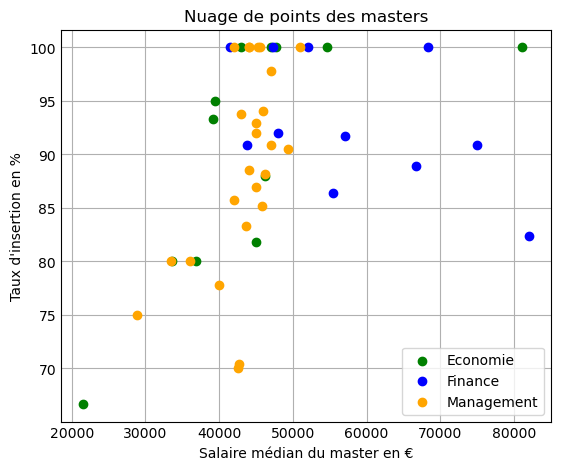

In [11]:
# Définition des couleurs pour chaque catégorie
plt.style.use('_mpl-gallery')
couleurs = {1: 'green', 2: 'blue', 3: 'orange'}
plt.figure(figsize=(5, 4))
légende = ['Economie', 'Finance', 'Management']

# Création du nuage de points avec différentes couleurs pour chaque catégorie
for categorie, groupe in master_df.groupby('Type de Master'):
    plt.scatter(groupe['Salaire médian en €'], groupe["Taux d'insertion en %"], c=couleurs[categorie])
 
# Affichage du nuage de points avec légendes
plt.legend(légende, loc='lower right')
plt.xlabel('Salaire médian du master en €')
plt.ylabel('Taux d\'insertion en %')
plt.title('Nuage de points des masters')
plt.show()

## Conclusion :

En conclusion, la problématique initiale cherchant à comprendre les écarts de salaires médians et les taux d'insertion professionnelle entre les diplômés des branches de la finance, de l'économie et du management à l'Université Paris-Dauphine trouve ici une réponse. 

Les diplômés de finance de Dauphine ont une performance remarquable avec un taux d'insertion de 93%, surpassant nettement la moyenne nationale de 88% pour les titulaires d'un Bac +5 un an après l'obtention de leur diplôme*. 

Cette supériorité du taux d'insertion s'accompagne de salaires médians qui excèdent significativement le salaire médian en France de 23 160 euros annuels rapporté en 2022*, ce qui démontre l'excellence et la reconnaissance de la formation en finance de Dauphine sur le marché du travail.

Quant aux secteurs de l'économie et du management, ils affichent également de bons résultats. 
Ces données reflètent l'adéquation des programmes de Dauphine avec les besoins du marché de l'emploi et soulignent l'engagement de l'université à fournir une formation de pointe qui ouvre des perspectives de carrières fructueuses et bien rémunérées.

_*Des recherches annexes ont été effectuées afin de mieux saisir et de comprendre les valeurs de salaire médian nous intriguant et d’en faire une analyse holistique et plus approfondie._